In [45]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt


# Demanda futura estimada (Dados do Excel, atualizados anualmente: Demanda Futura Projetada * [(ultima demanda realizada)/(última demanda projetada))
medias_metro = np.array([399488, 408966, 417891, 426778, 435648, 444434,
                         452759, 458717, 463483, 467055, 469465, 471431,
                         472936, 474171, 475086, 475998, 476280, 476280])
medias_ba052 = np.array([2678, 2772, 2868, 2969, 3072, 3190, 3317, 3450, 3587,
                         3730, 3840, 3936, 4033])
medias_ponte = np.array([28879, 30743, 32603, 34457, 36304, 38136, 39954, 41753,
                         43533, 45300, 47067, 48841, 50635, 52455, 54314, 56220,
                         58185, 60216, 62325, 64520, 66815, 69216, 71733, 74376,
                         77158, 80081, 83119, 86246, 89430])

# desvio padrão = 5% da média (Premissa: 10% de variação da demanda, situação sem contrapartida financeira, equivale a 95% dos casos. 
# Ou seja 2 desvios padrão da distribuição normal )
sigma_metro = medias_metro * 0.05
sigma_ba052 = medias_ba052 * 0.05
sigma_ponte = medias_ponte * 0.05

delay_ponte = 6  # anos iniciais zero para a ponte

# Correlações entre as 3 variáveis(Fonte: Planilha Excel)
correl_metro_ba052 = 0.9662
correl_metro_ponte = 0.9286
correl_ba052_ponte = 0.9971

corr = np.array([
    [1.0, correl_metro_ba052, correl_metro_ponte],
    [correl_metro_ba052, 1.0, correl_ba052_ponte],
    [correl_metro_ponte, correl_ba052_ponte, 1.0]
])

# Se a matriz não for PSD, regularizar (nearPD)
# (mantém correlações próximas e evita erro do multivariate_normal)
eps = 1e-8
corr = (corr + corr.T) / 2
eigvals, eigvecs = np.linalg.eigh(corr)
eigvals[eigvals < eps] = eps
corr_psd = eigvecs @ np.diag(eigvals) @ eigvecs.T

# Número de cenários
n_scenarios = 500

# Número máximo de anos entre as séries (considerando delay da ponte)
n_years = max(len(medias_metro), len(medias_ba052), len(medias_ponte) + delay_ponte)

# Inicializa saídas (cada linha = um cenário; cada coluna = ano)
sim_metro = np.zeros((n_scenarios, n_years))
sim_ba052 = np.zeros((n_scenarios, n_years))
sim_ponte = np.zeros((n_scenarios, n_years))

# Criar um gerador MVN para obter vetores correlacionados por ano
mvnorm = ss.multivariate_normal(mean=[0,0,0], cov=corr_psd)

# Para cada ano, draw n_scenarios vetores 3-d e transformar via cópula (cdf/ppf)
for year in range(n_years):
    # 1) gerar n_scenarios draws multivariados (forma (n_scenarios, 3))
    Z = mvnorm.rvs(size=n_scenarios)
    # garantir 2D mesmo quando n_scenarios == 1
    if n_scenarios == 1:
        Z = Z.reshape(1, 3)
    # 2) converter para uniformes via CDF da N(0,1)
    U = ss.norm.cdf(Z)  # shape (n_scenarios, 3)

    # 3) para cada coluna (variável), aplicar ppf da marginal correta para ESTE ano (se existir)
    # Metro: se year < len(medias_metro) aplica, senão deixa 0
    if year < len(medias_metro):
        mu = medias_metro[year]
        s = sigma_metro[year]
        sim_metro[:, year] = ss.norm.ppf(U[:, 0], loc=mu, scale=s)
    else:
        sim_metro[:, year] = 0.0

    # BA-052
    if year < len(medias_ba052):
        mu = medias_ba052[year]
        s = sigma_ba052[year]
        sim_ba052[:, year] = ss.norm.ppf(U[:, 1], loc=mu, scale=s)
    else:
        sim_ba052[:, year] = 0.0

    # Ponte: aplicar delay (ponte começa em ano = delay_ponte)
    ponte_idx = year - delay_ponte
    if ponte_idx >= 0 and ponte_idx < len(medias_ponte):
        mu = medias_ponte[ponte_idx]
        s = sigma_ponte[ponte_idx]
        sim_ponte[:, year] = ss.norm.ppf(U[:, 2], loc=mu, scale=s)
    else:
        sim_ponte[:, year] = 0.0

# Se n_scenarios == 1, extrai vetores 1D para inspeção
if n_scenarios == 1:
    sim_metro = sim_metro.ravel()
    sim_ba052 = sim_ba052.ravel()
    sim_ponte = sim_ponte.ravel()

# --- Resultado: uma trajetória (1 cenário) por série ---
print("metro:", sim_metro[:len(medias_metro)])        # anos válidos metro
print("ba052:", sim_ba052[:len(medias_ba052)])       # anos válidos ba052
print("ponte:", sim_ponte[:len(medias_ponte)+delay_ponte])  # inclui delay


metro: [[395303.51779787 405440.57744423 446525.95800379 436419.90919363
  432220.42716082 414982.6721909  465140.59668231 490937.48800433
  445820.38303254 482205.64204266 486418.64772996 443380.53098932
  476728.74562481 519686.93011637 458818.07207206 481434.12237932
  470871.95048731 500061.12921241      0.              0.
       0.              0.              0.              0.
       0.              0.              0.              0.
       0.              0.              0.              0.
       0.              0.              0.        ]
 [413479.26929953 399559.5444086  426359.09595131 380681.44937984
  394679.33536378 437188.44568542 462059.55568181 432165.19666265
  469755.41839148 492361.88218629 490713.82808714 502951.50630287
  420308.65526765 500984.06444412 466896.59620342 435267.28207341
  456674.37257369 516060.80543493      0.              0.
       0.              0.              0.              0.
       0.              0.              0.              0.
       0

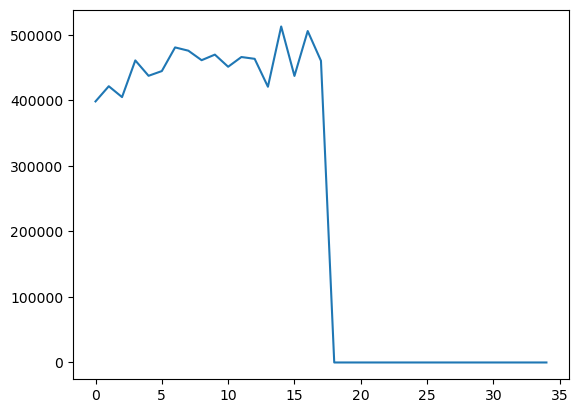

In [52]:
# Visualizar um cenário de demanda
plt.plot(sim_metro[258])